# Question 3

This script walks through the design of a band pass FIR filter using the window method.

In [91]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from a2_config import A2_ROOT, SAVEFIG_CONFIG

In [92]:
# Some filter configuration parameters
FS      = 40    # sampling frequency, kHz
DELTA_F = 1     # transition width, kHz
A       = 60    # stop band attenuation, dB
F1      = 4     # band pass start, kHz
F2      = 6     # band pass stop, kHz

In [93]:
# Initial estimate of filter length using Harris formula
N = int(np.ceil((FS / DELTA_F) * (A / 22)))
print("Filter length estimate:", N)

Filter length estimate: 110


Create the frequency domain vector, $V$, which represents the ideal frequency response.

Bins in passband: 6


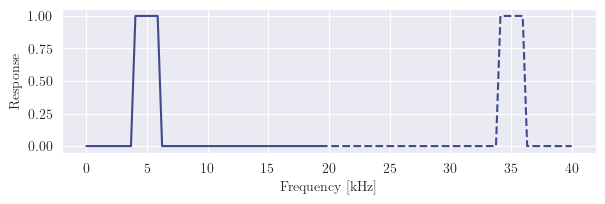

In [94]:
# Calculate pass band width, L
L = int(np.round(N * (F2 - F1) / FS))
print("Bins in passband:", L)

# Construct V, with 1's in the pass band and 0's in the stop band
L_idx = np.where(np.linspace(0, FS, N) >= F1)[0][0]
V = np.zeros(N//2)
V[L_idx:L_idx+L] = np.ones(L)
V = np.concatenate([V, V[::-1]])

# Construct a frequency axis for plotting
f = np.linspace(0, FS, N)

# Plot the ideal frequency response, represented by vector V
fig, ax = plt.subplots(figsize=(6, 2))
fig.tight_layout()

palette = sns.color_palette()

sns.lineplot(x=f[:N//2], y=V[:N//2], ax=ax, c=palette[0], ls="-")
sns.lineplot(x=f[N//2:], y=V[N//2:], ax=ax, c=palette[0], ls="--")

ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel("Response")

fname = Path(A2_ROOT, "output", "q3_ideal_freqz.png")
fig.savefig(fname, **SAVEFIG_CONFIG)

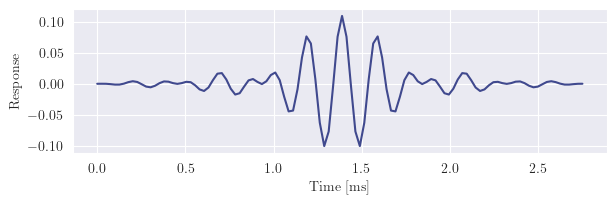

In [95]:
from scipy.fft import fft, fftshift, ifft

# Impulse (time) response of ideal filter
v = fftshift(ifft(V))

# Plot the ideal impulse response
fig, ax = plt.subplots(figsize=(6, 2))
fig.tight_layout()

t = np.linspace(0, N/FS, N)
sns.lineplot(x=t, y=v.real, ax=ax)

ax.set_xlabel("Time [ms]")
ax.set_ylabel("Response")

fname = Path(A2_ROOT, "output", "q3_ideal_impz.png")
fig.savefig(fname, **SAVEFIG_CONFIG)

/tmp/ipykernel_31569/1847007380.py:9: RuntimeWarning: divide by zero encountered in log10
  dB = lambda x: 20 * np.log10(x)


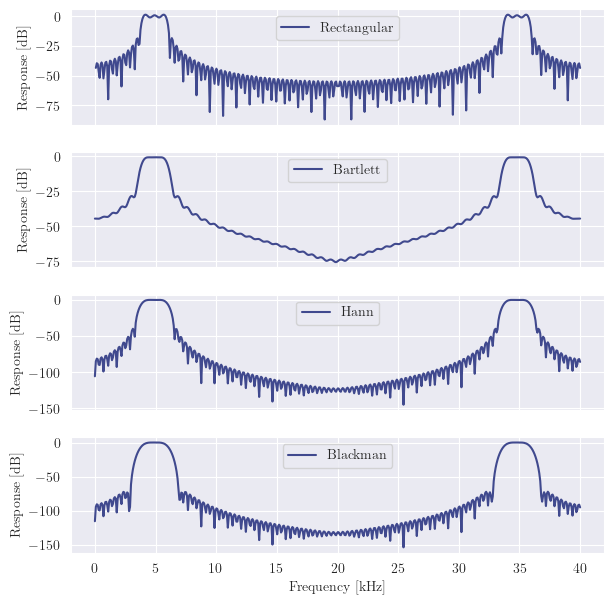

In [96]:
from scipy.signal.windows import bartlett, blackman, boxcar, hann

V_boxcar   = np.round(np.abs(fft(v * boxcar(N),   512)), decimals=10)
V_bartlett = np.round(np.abs(fft(v * bartlett(N), 512)), decimals=10)
V_hann     = np.round(np.abs(fft(v * hann(N),     512)), decimals=10)
V_blackman = np.round(np.abs(fft(v * blackman(N), 512)), decimals=10)

# Helper function for converting frequency response to dB scale
dB = lambda x: 20 * np.log10(x)

# Construct a frequency axis for plotting
f = np.linspace(0, FS, 512)

# Plot the comparison
fig, axs = plt.subplots(4, figsize=(6, 6), sharex=True)
fig.tight_layout()

sns.lineplot(x=f, y=dB(V_boxcar),   ax=axs[0], label="Rectangular")
sns.lineplot(x=f, y=dB(V_bartlett), ax=axs[1], label="Bartlett")
sns.lineplot(x=f, y=dB(V_hann),     ax=axs[2], label="Hann")
sns.lineplot(x=f, y=dB(V_blackman), ax=axs[3], label="Blackman")

axs[3].set_xlabel("Frequency [kHz]")

axs[0].set_ylabel("Response [dB]")
axs[1].set_ylabel("Response [dB]")
axs[2].set_ylabel("Response [dB]")
axs[3].set_ylabel("Response [dB]")

axs[0].legend(loc="upper center")
axs[1].legend(loc="upper center")
axs[2].legend(loc="upper center")
axs[3].legend(loc="upper center")

fname = Path(A2_ROOT, "output", "q3_window_freqzs.png")
fig.savefig(fname, **SAVEFIG_CONFIG)

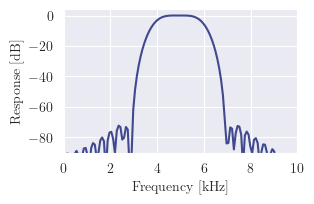

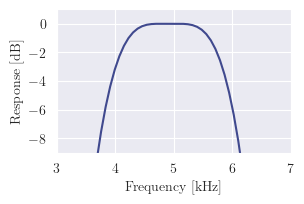

In [97]:
# Provide zoomed-in views to judge pass and stop band specifications
# 1st view
fig, ax = plt.subplots(figsize=(3, 2))
fig.tight_layout()

sns.lineplot(x=f, y=dB(V_blackman), ax=ax)

ax.set_xlim([0, 10])
ax.set_ylim([-90, 4])

ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel("Response [dB]")

fname = Path(A2_ROOT, "output", "q3_zoom_1.png")
fig.savefig(fname, **SAVEFIG_CONFIG)

# 2nd view
fig, ax = plt.subplots(figsize=(3, 2))
fig.tight_layout()

sns.lineplot(x=f, y=dB(V_blackman), ax=ax)

ax.set_xlim([3, 7])
ax.set_ylim([-9, 1])

ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel("Response [dB]")

fname = Path(A2_ROOT, "output", "q3_zoom_2.png")
fig.savefig(fname, **SAVEFIG_CONFIG)

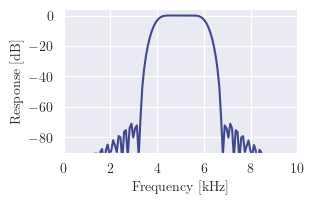

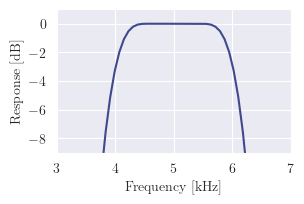

In [98]:
# Increase N until roll-off specification is met
N = 160

L = int(np.round(N * (F2 - F1) / FS)) + 1
L_idx = np.where(np.linspace(0, FS, N) >= F1)[0][0]
V = np.zeros(N//2)
V[L_idx:L_idx+L] = np.ones(L)
V = np.concatenate([V, V[::-1]])

v = fftshift(ifft(V))
V_blackman = np.round(np.abs(fft(v * blackman(N), 512)), decimals=10)

# Plot the same zoomed views of the longer filter
# 1st view
fig, ax = plt.subplots(figsize=(3, 2))
fig.tight_layout()

sns.lineplot(x=f, y=dB(V_blackman), ax=ax)

ax.set_xlim([0, 10])
ax.set_ylim([-90, 4])

ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel("Response [dB]")

fname = Path(A2_ROOT, "output", "q3_zoom_3.png")
fig.savefig(fname, **SAVEFIG_CONFIG)

# 2nd view
fig, ax = plt.subplots(figsize=(3, 2))
fig.tight_layout()

sns.lineplot(x=f, y=dB(V_blackman), ax=ax)

ax.set_xlim([3, 7])
ax.set_ylim([-9, 1])

ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel("Response [dB]")

fname = Path(A2_ROOT, "output", "q3_zoom_4.png")
fig.savefig(fname, **SAVEFIG_CONFIG)

In [ ]:
# Optimal filter design using Parks-McClelland (Remez exchange) method
from scipy.signal import remez